In [1]:
# maximize reproducibility: set seed with minimal imports
# just a seed
seed = 431136
import os

# verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# reproducibility
# https://github.com/NVIDIA/framework-determinism
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random

random.seed(seed)
rng_r = random.Random(seed + 1)

import numpy as np

np.random.seed(seed + 2)
rng_np = np.random.default_rng(seed + 3)

import tensorflow as tf

tf.random.set_seed(seed + 4)

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import seaborn as sns

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from posthoceval.explainers import KernelSHAPExplainer
from posthoceval.models.gam import MultiClassLogisticGAM
from posthoceval.models.gam import LinearGAM
from posthoceval.models.gam import T
from posthoceval.models.dnn import AdditiveDNN
from posthoceval.transform import Transformer
from posthoceval.utils import nonexistent_filename
from posthoceval.datasets import COMPASDataset
from posthoceval.datasets import BostonDataset
from posthoceval.datasets import HELOCDataset
from posthoceval.models.term_util import generate_terms
from posthoceval.viz import gather_viz_data

In [3]:
sns.set_theme(
    context='paper',
    # context='notebook',
    style='ticks',
    font_scale=2.25,
    color_codes=True,
    # palette=sns.color_palette('pastel'),
)

In [4]:
def mpl_backend(backend='inline'):
    rc = plt.rcParams.copy()
    # backend = plt.get_backend()
    %matplotlib $backend
    
mpl_inline = lambda: mpl_backend('inline')
mpl_qt = lambda: mpl_backend('qt')
mpl_notebook = lambda: mpl_backend('notebook')
mpl_backend('nbagg')

In [5]:
dataset_name = 'heloc'

if dataset_name == 'synthetic':
    raise NotImplementedError
    task = 'regression'

    # import numpy
    # X = np.random.rand(1000, 8) / 4
    # x1, x2, x3, x4, x5, x6, x7, x8 = X.T
    # y = (x1 ** 2 + x5 ** 2 + x5 * numpy.log(x1 + x2) +
    #      x7 * numpy.select([numpy.greater(x2, numpy.sinc(x1 / numpy.pi)),
    #                         True],
    #                        [numpy.asarray(x2 ** (-1.0)).astype(numpy.bool),
    #                         numpy.asarray(numpy.sinc(x1 / numpy.pi) ** (-1.0)
    #                                       ).astype(numpy.bool)],
    #                        default=numpy.nan) + (
    #              x1 * abs(x7) + x5) ** 3 + numpy.exp(x7) + numpy.exp(
    #             (x1 + x2) / x5) + numpy.sin(numpy.log(x2)))

    # X = np.random.randn(1000, 4)
    # x1, x2, x3, x4 = X.T
    # x1 = np.abs(x1)
    # x2 = np.abs(x2)
    # y = x1 ** (1 / 4) + np.sqrt(x2) + np.exp(x3 / 2) + np.abs(x4) + np.tan(
    #     x4) / x1 ** 2

    # X = np.random.randn(1000, 2)
    # y = X[:, 0] ** 9 + np.tan(X[:, 1]) + np.abs(X[:, 0] / X[:, 1] ** 2)

    # X = np.random.randn(1000, 400)
    # y = np.exp(np.random.randn(len(X)))

    # X[:, 1] = X[:, 0] / 2
    # X[:, 2] = X[:, 1] + 1
    # X[:, 3] = X[:, 2] * 2.6
    # y = (np.sin(X[:, 0] ** 3) + np.maximum(X[:, 1], 0)
    #     - np.sin(X[:, 2]) / X[:, 2] + 2 * X[:, 3])

    feature_names = [*range(X.shape[1])]
elif dataset_name == 'compas':
    dataset_cls = COMPASDataset
elif dataset_name == 'heloc':
    dataset_cls = HELOCDataset
elif dataset_name == 'boston':
    dataset_cls = BostonDataset
else:
    raise NotImplementedError
    task = 'classification'
    # dataset = datasets.load_iris()
    # dataset = datasets.load_breast_cancer()
    dataset = datasets.load_wine()

    X = dataset.data
    y = dataset.target

# load dataset
dataset_orig = dataset_cls()

# transform data
transformer = Transformer()
dataset = transformer.fit_transform(dataset_orig)

# extract data
task = dataset.task
X = dataset.X
y = dataset.y
feature_names = dataset.feature_names
n_features = dataset.n_features

print(f'Samples     = {len(X)}')
print(f'Input Shape = {dataset.input_shape}')
print(f'Task        = {task}')

Samples     = 10459
Input Shape = (37,)
Task        = classification


In [6]:
# model
# model_type = 'gam'
model_type = 'dnn'

In [8]:
# put together terms
if dataset_name == 'heloc':
    desired_interactions = [(1, 2), (10, 12), (15, 18), (7, 11)]
else:
    desired_interactions = []

# current interact plots use this: LIME, MAPLE
# desired_interactions = [(1, 2)]

# features 8 & 9 correlate in Boston dataset
# desired_interactions = [(8, 0, 1), (2, 8), (2, 9)]
# desired_interactions = [(5, 8), (5, 9)]
# desired_interactions = [(2, 8), (5, 9)]

# desired_interactions = [(1, 2), (4, 9), (8, 10)]

# desired_interactions = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11, 12)]
# desired_interactions = [(0, 1, 2, 3), (4, 5), (6, 7), (8, 9), (10, 11, 12)]
# desired_interactions = [(0, 1, 2, 3), (4, 5), (6, 7), (8, 9), (10, 11, 12),
#                         (220, 101)]

max_order = 2
min_order = 1
n_main = n_features
n_interact = None if desired_interactions else None

terms = generate_terms(
    n_features=n_features,
    n_main=n_main,
    n_interact=n_interact,
    desired_interactions=desired_interactions,
    min_order=min_order,
    max_order=max_order,
    seed=rng_np,
)
# terms = [T.te(0, 1), T.te(2, 3), T.s(0, n_splines=50)]
# terms = [T.te(0, 1), T.te(1, 3, n_splines=5), T.s(2, n_splines=50)]

In [9]:
if model_type == 'dnn':
    callback = EarlyStopping(monitor='loss', mode='min', patience=100,
                             restore_best_weights=True)
    optimizer = Adam(learning_rate=1e-3)
    fit_kwargs = {'epochs': 100, 'batch_size': len(X),
                  'callbacks': [callback], 'optimizer': optimizer}
else:
    fit_kwargs = {}

# TODO: factor terms for categoricals in GAM?
# TODO: embed categoricals in NN?

if model_type == 'dnn':
    model = AdditiveDNN(
        terms=terms,
        task=task,
        symbol_names=feature_names,
        activation='sigmoid',
    )
elif model_type == 'gam':
    if task == 'classification':
        model = MultiClassLogisticGAM(symbol_names=feature_names, terms=terms)
    else:
        model = LinearGAM(symbol_names=feature_names, terms=terms)
else:
    raise NotImplementedError(model_type)

model.fit(X, y, **fit_kwargs)

if model_type == 'dnn':
    model.plot_model(nonexistent_filename('dnn.png'),
                     show_shapes=True)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 2.6770
Epoch 2/100
1/1 [==============================] - 0s 101ms/step - loss: 0.6934
Epoch 3/100
1/1 [==============================] - 0s 86ms/step - loss: 1.7268
Epoch 4/100
1/1 [==============================] - 0s 80ms/step - loss: 1.6170
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 0.9112
Epoch 6/100
1/1 [==============================] - 0s 79ms/step - loss: 0.8192
Epoch 7/100
1/1 [==============================] - 0s 83ms/step - loss: 1.2569
Epoch 8/100
1/1 [==============================] - 0s 76ms/step - loss: 1.2018
Epoch 9/100
1/1 [==============================] - 0s 78ms/step - loss: 0.8271
Epoch 10/100
1/1 [==============================] - 0s 81ms/step - loss: 0.7139
Epoch 11/100
1/1 [==============================] - 0s 80ms/step - loss: 0.9597
Epoch 12/100
1/1 [==============================] - 0s 78ms/step - loss: 1.0439
Epoch 13/100
1/1 [==============================] 

In [10]:
explain_only_this_many = 500
# explain_only_this_many = len(X)
explain_only_this_many = min(explain_only_this_many, len(X))
sample_idxs_all = np.arange(len(X))
sample_idxs = rng_np.choice(sample_idxs_all,
                            size=explain_only_this_many, replace=False)
X_subset = X[sample_idxs]

true_contribs = model.feature_contributions(X_subset)

In [11]:
explainer_array = (
    # ('LIME',
    #  LIMEExplainer(model, seed=seed, task=task)),
    # ('MAPLE',
    #  MAPLEExplainer(model, seed=seed, task=task)),
    ('SHAP',
     KernelSHAPExplainer(model, task=task, seed=seed,
                         n_cpus=1 if model_type == 'dnn' else -1)),
)

# TODO: feature_contributions() --> explain()
# TODO: explain() --> ExplainerMixin (for both models and explainers)

pred_contribs_map = {}
pred_y_map = {}
for expl_i, (explainer_name, explainer) in enumerate(explainer_array):
    print('Explaining model using', explainer_name)
    explainer.fit(dataset)  # fit full dataset
    pred_contribs, y_pred = explainer.feature_contributions(
        X_subset, as_dict=True, return_predictions=True)

    # store for later viz data generation
    pred_contribs_map[explainer_name] = pred_contribs
    pred_y_map[explainer_name] = y_pred

Explaining model using SHAP


  0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
# TODO: import from viz and implement fully...
# plot_fit()

df, df_3d, err_dfs = gather_viz_data(
    model=model,
    dataset=dataset,
    transformer=transformer,
    true_contribs=true_contribs,
    pred_contribs_map=pred_contribs_map,
    dataset_sample_idxs=sample_idxs,
)

               Metric         Score Explainer                  Class
0    paired_distances  4.488805e-07      SHAP  RiskPerformance = Bad
1    paired_distances  4.463870e-07      SHAP  RiskPerformance = Bad
2    paired_distances  4.501390e-07      SHAP  RiskPerformance = Bad
3    paired_distances  4.445436e-07      SHAP  RiskPerformance = Bad
4    paired_distances  4.435585e-07      SHAP  RiskPerformance = Bad
..                ...           ...       ...                    ...
995  paired_distances  4.871272e-03      SHAP  RiskPerformance = Bad
996  paired_distances  4.875580e-03      SHAP  RiskPerformance = Bad
997  paired_distances  4.870800e-03      SHAP  RiskPerformance = Bad
998  paired_distances  4.870375e-03      SHAP  RiskPerformance = Bad
999  paired_distances  4.869797e-03      SHAP  RiskPerformance = Bad

[1000 rows x 4 columns]
               Metric         Score Explainer                   Class
0    paired_distances  3.036135e-07      SHAP  RiskPerformance = Good
1    pa

<IPython.core.display.Javascript object>


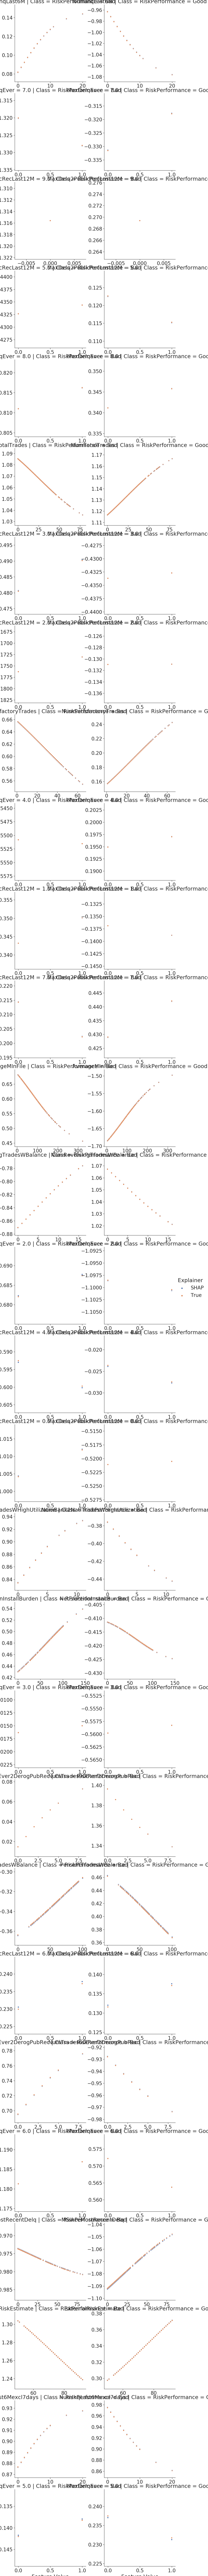

In [13]:
col_wrap = 4

if df is not None:
    # if n_features > 12 or task == 'classification':
    #     mpl_qt()
    # else:
    #     mpl_inline()
    g = sns.relplot(
        data=df,
        x='Feature Value',
        y='Contribution',
        hue='Explainer',
        # col='class' if task == 'classification' else 'true_effect',
        col='Class' if task == 'classification' else 'Match',
        col_wrap=None if task == 'classification' else col_wrap,
        # row='true_effect' if task == 'classification' else None,
        row='Match' if task == 'classification' else None,
        kind='scatter',
        x_jitter=.08,  # for visualization purposes of nearby points
        alpha=.65,
        facet_kws=dict(sharex=False, sharey=False),
    )
    for ax in g.axes.flat:
        title = ax.get_title()
        ax.set_title(title.split(' = ', 1)[1])
    g.tight_layout()
    g.savefig(nonexistent_filename(f'contributions_grid_{model_type}.pdf'))

<IPython.core.display.Javascript object>


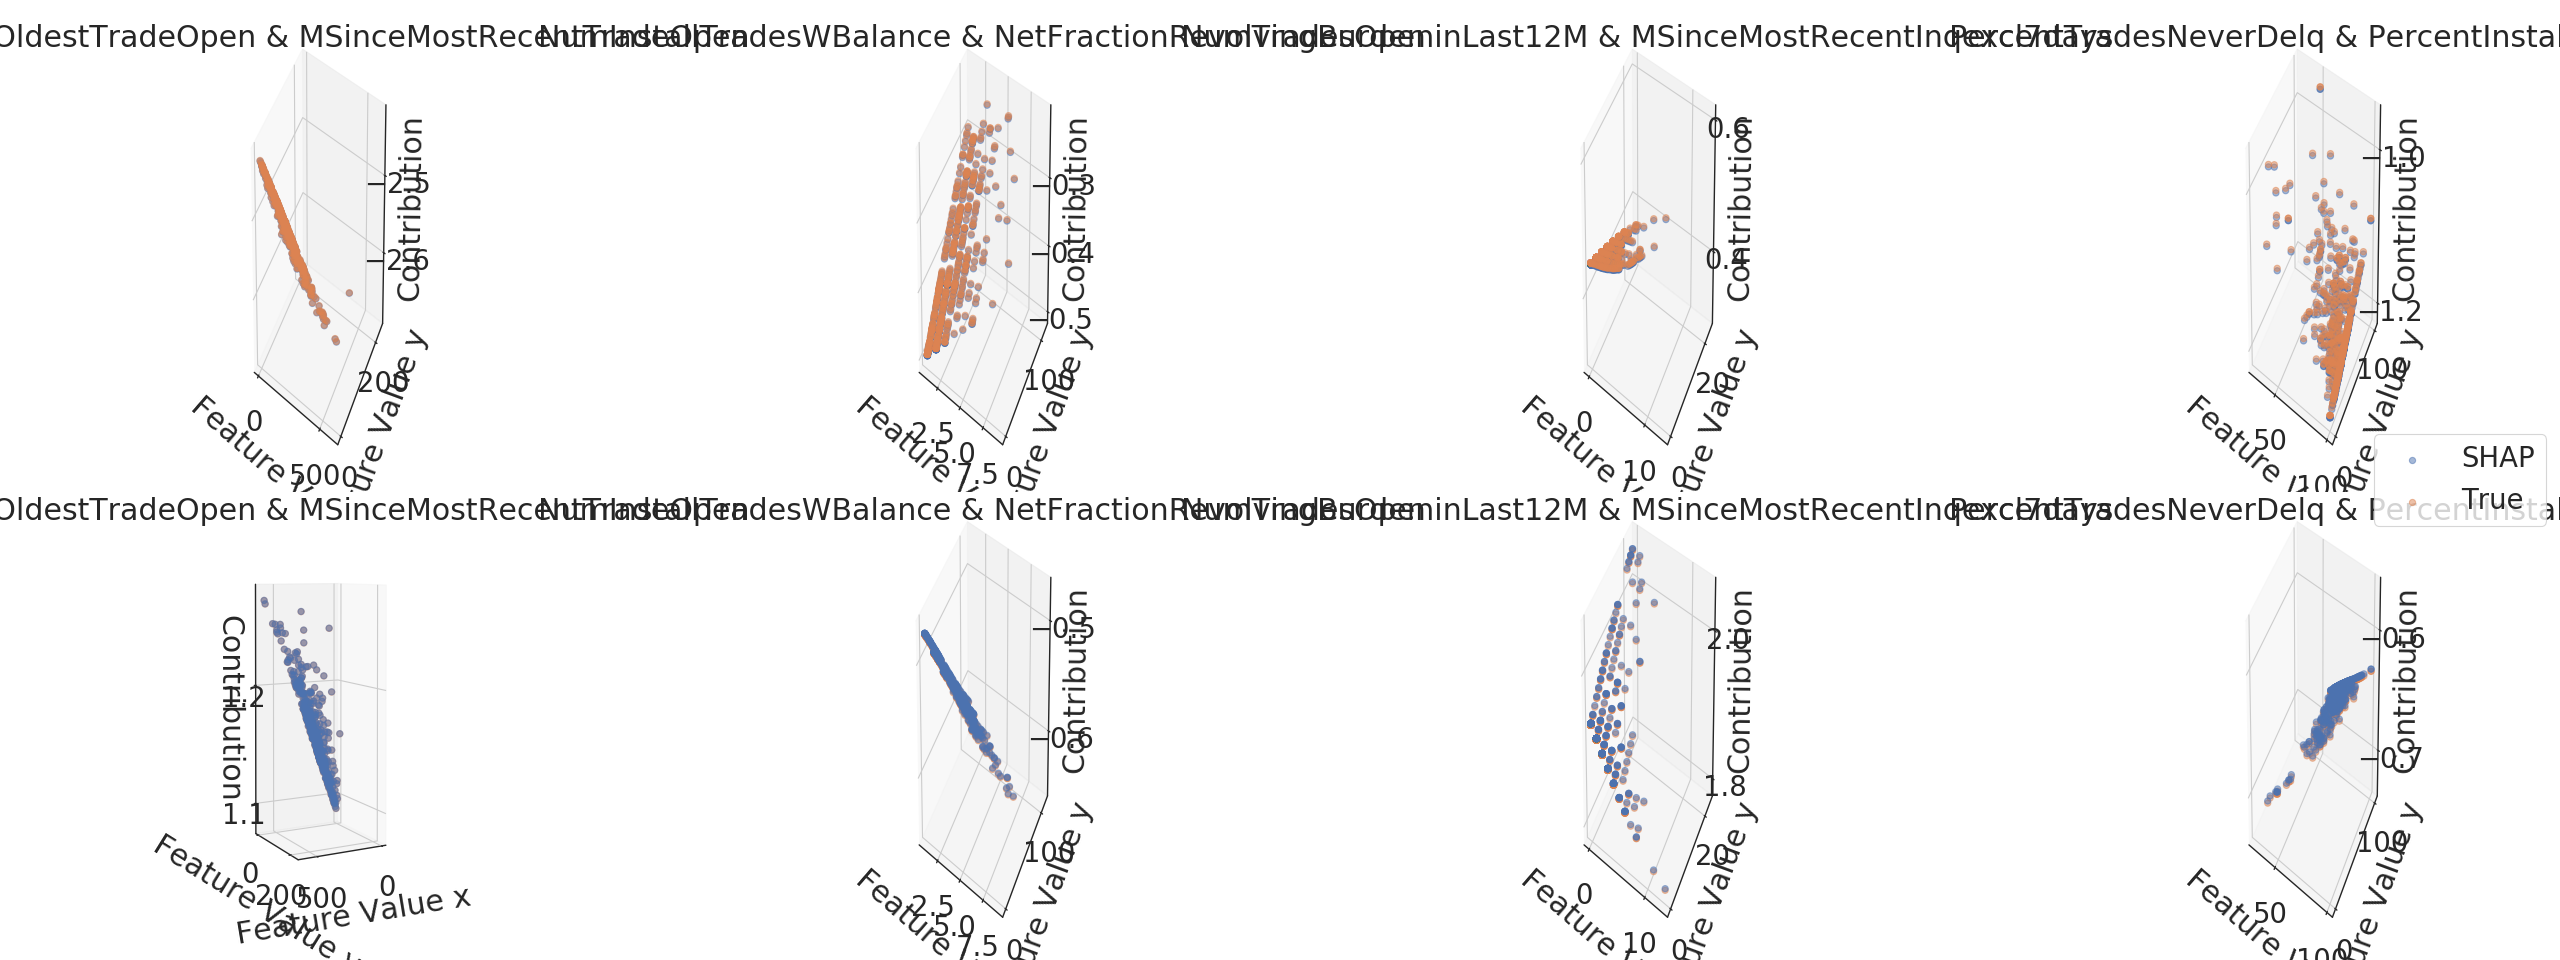

In [14]:
# 3d interaction plot time
if df_3d is not None:

    plt_x = 'Feature Value x'
    plt_y = 'Feature Value y'
    plt_z = 'Contribution'
    plt_hue = 'Explainer'
    plt_col = 'Match'

    df_3d_grouped = df_3d.groupby(['Class', plt_col])

    n_plots = len(df_3d_grouped)
    n_rows = int(np.ceil(n_plots / col_wrap))
    n_cols = min(col_wrap, n_plots)
    figsize = plt.rcParams['figure.figsize']
    figsize = (figsize[0] * n_cols, figsize[1] * n_rows)
    fig = plt.figure(figsize=figsize)

    for i, ((class_i, ax_title), group_3d) in enumerate(df_3d_grouped):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')

        for hue_name, hue_df in group_3d.groupby(plt_hue):
            ax.scatter(
                hue_df[plt_x],
                hue_df[plt_y],
                hue_df[plt_z],
                label=hue_name,
                alpha=.5,
            )
        ax.set_xlabel(plt_x)
        ax.set_ylabel(plt_y)
        ax.set_zlabel(plt_z)

        ax.set_title(ax_title)

        if i == 0:
            fig.legend(loc='center right')
    fig.tight_layout()
    fig.savefig(nonexistent_filename(
        f'contributions_grid_interact_{model_type}.pdf'))